### Importing libraries, some global settings, etc.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from scipy.stats import hypergeom
import random
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,}'.format


# Appendix B

In [2]:
#here, we read the raw network data and process it to an edgelist. 
df = pd.read_csv('oecd_2019.csv', index_col=0, decimal='.')
df.values[[np.arange(len(df))]*2] = np.nan
oecd_exports = df.stack().reset_index()
oecd_exports.iloc[:, 2] = pd.to_numeric(oecd_exports.iloc[:, 2]).round(2)
oecd_exports.columns = ['source', 'target', 'weight_in_1000USD']
oecd_exports.head()

<ipython-input-2-15e7902530e5>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df.values[[np.arange(len(df))]*2] = np.nan


,source,target,weight_in_1000USD
0,AUS: Australia,AUT: Austria,"21,388.11"
1,AUS: Australia,BEL: Belgium,"946,518.07"
2,AUS: Australia,CAN: Canada,"1,517,281.47"
3,AUS: Australia,CHL: Chile,"227,386.81"
4,AUS: Australia,COL: Colombia,"25,499.08"


In [3]:
##calculate necessary quantities for hypergeometric distribution

edgedf = pd.DataFrame(oecd_exports.values, columns =  ['i', 'j', 'Wij'])

# outgoing strength for i
edgedf = pd.merge(edgedf, 
					 edgedf[['i','Wij']].groupby('i', as_index=False).sum().rename(columns ={'Wij':'Wi.'}),
					 left_on = 'i', right_on = 'i')
	
# incoming strength for j
edgedf = pd.merge(edgedf, 
					 edgedf[['j','Wij']].groupby('j', as_index=False).sum().rename(columns ={'Wij':'W.j'}),
					 left_on = 'j', right_on = 'j')

# incoming strength for i
edgedf = pd.merge(edgedf, 
			edgedf[['j', 'W.j']].drop_duplicates(), 
			how = 'left', left_on = 'i', right_on = 'j', 
			suffixes=('', '_y') ).rename(columns ={'W.j_y':'W.i'}).drop(columns = ['j_y'])
   
# sum of all weights
edgedf['W..'] = edgedf['Wij'].sum()

edgedf.head()

,i,j,Wij,Wi.,W.j,W.i,W..
0,AUS: Australia,AUT: Austria,"21,388.11","96,830,854.13","151,678,693.37999997","100,503,901.07","7,773,117,491.599997"
1,BEL: Belgium,AUT: Austria,"4,487,520.41","377,290,148.88999987","151,678,693.37999997","306,262,036.42","7,773,117,491.599997"
2,CAN: Canada,AUT: Austria,"195,248.52","398,991,053.57","151,678,693.37999997","380,441,826.07","7,773,117,491.599997"
3,CHL: Chile,AUT: Austria,"79,361.36","32,095,715.429999996","151,678,693.37999997","35,582,838.29","7,773,117,491.599997"
4,COL: Colombia,AUT: Austria,"1,896.7","22,533,948.199999996","151,678,693.37999997","30,208,981.250000004","7,773,117,491.599997"


In [4]:
## CALCULATE CONFIDENCE INTERVALS BASED ON HYPERGEOMETRIC DISTRIBUTION

#   The hypergeometric distribution models drawing objects from a bin. M is the total number of objects, 
# n is total number of Type I objects. The random variate represents the number of Type I objects 
# in N drawn without replacement from the total population.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html

M = edgedf['W..'] - edgedf['W.i'] # number of alternative stubs to choose from (for a link from i to j)
n = edgedf['W.j'] # number of stubs belonging to j (for a link from i to j)
N = edgedf['Wi.'] # number of stubs to be selected to connect with i (for a link from i to j)

M, n, N =  M/10000, n/10000, N/10000 # original data is in thousand dollars. With this, the unit weight is 10M USD

interval_for_10M = hypergeom.interval(0.99999, M, n, N) # calculate the confidence interval with 99.999% confidence
edgedf['lb_10m'] = interval_for_10M[0] # lower bound of the interval (in 10M USD)
edgedf['ub_10m'] = interval_for_10M[1] # upper bound of the interval (in 10M USD)

M, n, N =  M/10, n/10, N/10 # Further divide by 10. So that, the unit weight is now 100M USD

interval_for_100M = hypergeom.interval(0.99999, M, n, N) # calculate the confidence interval where 99.999% confidence
edgedf['lb_100m'] = interval_for_100M[0] # lower bound of the interval (in 100M USD)
edgedf['ub_100m'] = interval_for_100M[1] # upper bound of the interval (in 100M USD)


edgedf['lb_10m'], edgedf['ub_10m'] = edgedf['lb_10m']*10000, edgedf['ub_10m']*10000 # bring interval back to the original 1000 USD unit
edgedf['lb_100m'], edgedf['ub_100m'] = edgedf['lb_100m']*100000, edgedf['ub_100m']*100000 # bring interval back to the original 1000 USD unit

edgedf.head()

,i,j,Wij,Wi.,W.j,W.i,W..,lb_10m,ub_10m,lb_100m,ub_100m
0,AUS: Australia,AUT: Austria,"21,388.11","96,830,854.13","151,678,693.37999997","100,503,901.07","7,773,117,491.599997","1,340,000.0","2,540,000.0","300,000.0","4,100,000.0"
1,BEL: Belgium,AUT: Austria,"4,487,520.41","377,290,148.88999987","151,678,693.37999997","306,262,036.42","7,773,117,491.599997","6,510,000.0","8,870,000.0","4,200,000.0","11,600,000.0"
2,CAN: Canada,AUT: Austria,"195,248.52","398,991,053.57","151,678,693.37999997","380,441,826.07","7,773,117,491.599997","7,000,000.0","9,430,000.0","4,600,000.0","12,300,000.0"
3,CHL: Chile,AUT: Austria,"79,361.36","32,095,715.429999996","151,678,693.37999997","35,582,838.29","7,773,117,491.599997","310,000.0","1,000,000.0",0.0,"2,000,000.0"
4,COL: Colombia,AUT: Austria,"1,896.7","22,533,948.199999996","151,678,693.37999997","30,208,981.250000004","7,773,117,491.599997","180,000.0","760,000.0",0.0,"1,600,000.0"


## Table 5

In [5]:
random.seed(99)
table_x = edgedf.iloc[random.sample(range(1, 100), 5),[0,1,2,7,8,9,10]]
table_x.columns = ['source', 'target', 'export_in_1000USD', 'LB_10M', 'UB_10M', 'LB_100M', 'UB_100M']
table_x

,source,target,export_in_1000USD,LB_10M,UB_10M,LB_100M,UB_100M
52,ITA: Italy,BEL: Belgium,"15,742,248.79","14,900,000.0","18,330,000.0","11,400,000.0","22,300,000.0"
49,ISL: Iceland,BEL: Belgium,"77,439.63","30,000.0","390,000.0",0.0,"1,000,000.0"
26,POL: Poland,AUT: Austria,"5,376,834.71","3,410,000.0","5,190,000.0","1,800,000.0","7,400,000.0"
77,CZE: Czech Republic,CAN: Canada,"337,201.49","7,560,000.0","10,090,000.0","5,100,000.0","13,000,000.0"
23,NLD: Netherlands,AUT: Austria,"7,013,139.08","8,360,000.0","10,990,000.0","5,800,000.0","14,000,000.0"


## Figure 6

In [6]:
edgedf['backbone_10M'] = np.where(edgedf.Wij < edgedf.lb_10m, -1, np.where(edgedf.Wij > edgedf.ub_10m, 1, 0))
edgedf['backbone_100M'] = np.where(edgedf.Wij < edgedf.lb_100m, -1, np.where(edgedf.Wij > edgedf.ub_100m, 1, 0))

Name: 
Type: DiGraph
Number of nodes: 37
Number of edges: 865
Average in degree:  23.3784
Average out degree:  23.3784


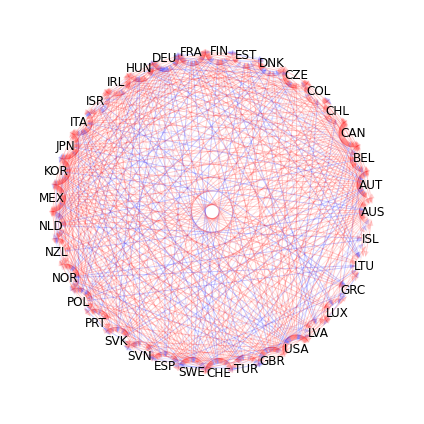

In [7]:
net_10M = nx.DiGraph()

for _, row in edgedf.iterrows():
  if row.backbone_10M != 0:
    net_10M.add_edge(row.i, row.j, weight=row.backbone_10M)

print(nx.info(net_10M))


backbone = net_10M

plt.rcParams['figure.figsize'] = [6, 6]
pos = nx.circular_layout(backbone)  # node positions

epos = [(u, v) for (u, v, d) in backbone.edges(data=True) if d["weight"] == 1]
eneg = [(u, v) for (u, v, d) in backbone.edges(data=True) if d["weight"] == -1]

#draw nodes
nx.draw_networkx_nodes(backbone, pos,  node_color='whitesmoke', node_size=0)

# labels
node_labels = {i: i[:3] for i in backbone.nodes}
nx.draw_networkx_labels(backbone, pos, labels=node_labels, font_size=12, font_family="sans-serif", )

# edges
nx.draw_networkx_edges(backbone, pos, edgelist=epos, width=1, edge_color="blue", alpha = 0.1)
nx.draw_networkx_edges(backbone, pos, edgelist=eneg, width=1, edge_color="red",  alpha = 0.1)



ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

Name: 
Type: DiGraph
Number of nodes: 37
Number of edges: 379
Average in degree:  10.2432
Average out degree:  10.2432


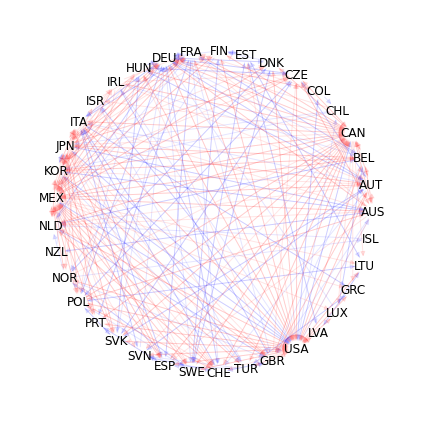

In [8]:
net_100M = nx.DiGraph()

for _, row in edgedf.iterrows():
  if row.backbone_100M != 0:
    net_100M.add_edge(row.i, row.j, weight=row.backbone_100M)

print(nx.info(net_100M))



backbone = net_100M

plt.rcParams['figure.figsize'] = [6, 6]
epos = [(u, v) for (u, v, d) in backbone.edges(data=True) if d["weight"] == 1]
eneg = [(u, v) for (u, v, d) in backbone.edges(data=True) if d["weight"] == -1]

#draw nodes
nx.draw_networkx_nodes(backbone, pos,  node_color='whitesmoke', node_size=0)

# labels
node_labels = {i: i[:3] for i in backbone.nodes}
nx.draw_networkx_labels(backbone, pos, labels=node_labels, font_size=12, font_family="sans-serif", )

# edges
nx.draw_networkx_edges(backbone, pos, edgelist=epos, width=1, edge_color="blue", alpha = 0.1)
nx.draw_networkx_edges(backbone, pos, edgelist=eneg, width=1, edge_color="red",  alpha = 0.1)



ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()